<a href="https://colab.research.google.com/github/luvbenz/2025-CV/blob/hw2/2-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Fig0943(a)(dark_blobs_on_light_background).tif to Fig0943(a)(dark_blobs_on_light_background) (43).tif


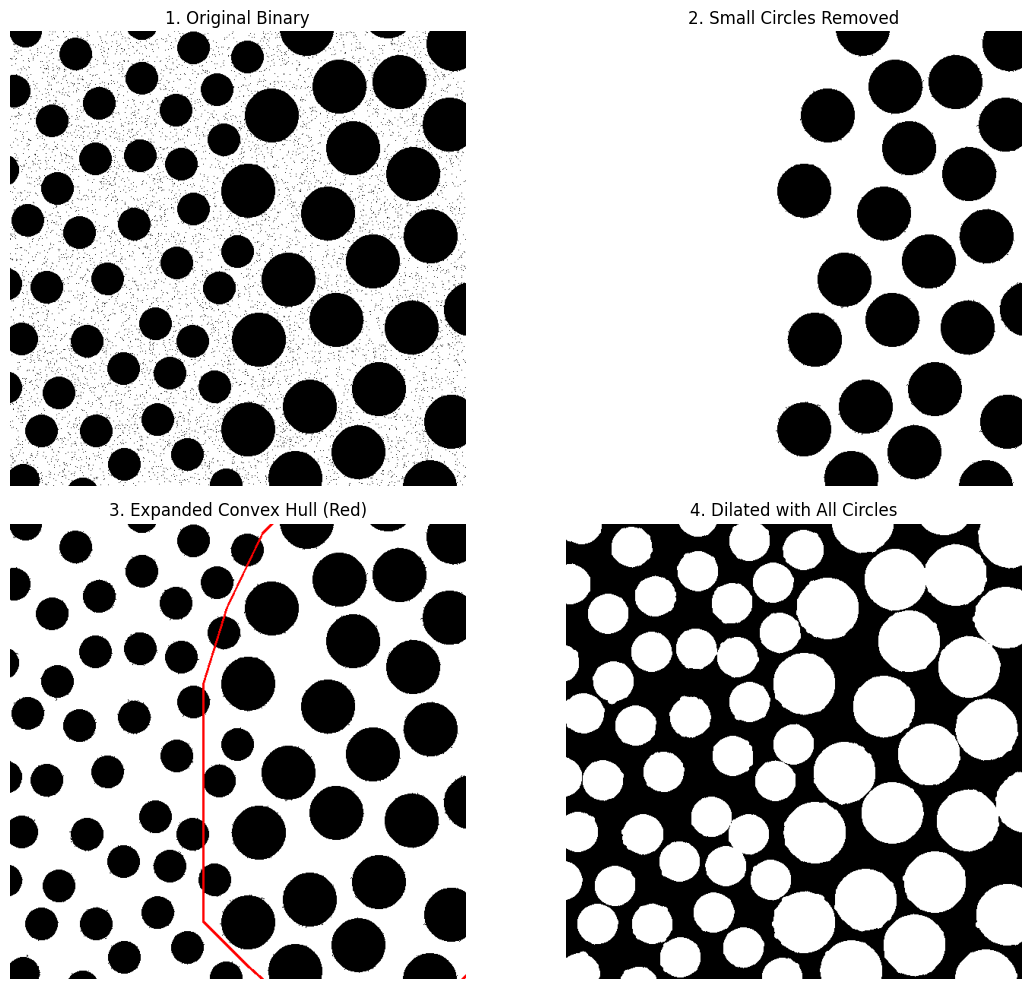

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from google.colab import files

# 🔽 1. 이미지 업로드
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

# 🔽 2. Otsu 이진화 + 반전
_, binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
inv = cv.bitwise_not(binary)

# 🔽 3. Connected Components 분석
num_labels, labels, stats, _ = cv.connectedComponentsWithStats(inv)

# 🔽 4. 큰 원 / 복원할 작은 원 / 무시할 아주 작은 원 분리
min_area_large = 1500
min_area_restore = 100
filtered = np.zeros_like(inv)
restored_small = np.zeros_like(inv)
centroids = []
radii = []

for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    if area >= min_area_large:
        filtered[labels == i] = 255
        yx = np.column_stack(np.where(labels == i))
        centroid = np.mean(yx, axis=0)
        centroids.append(centroid[::-1])  # (x, y)
        radii.append(np.sqrt(area / np.pi))
    elif area >= min_area_restore:
        restored_small[labels == i] = 255
    # else: area < 100 → 무시

# 🔽 5. 중심 기반 padding 적용 ConvexHull
stronger_padding = int(np.mean(radii)) + 25 if radii else 30
expanded_points = []
for pt in centroids:
    x, y = pt
    expanded_points.extend([
        [x + stronger_padding, y],
        [x - stronger_padding, y],
        [x, y + stronger_padding],
        [x, y - stronger_padding],
    ])
expanded_points = np.array(expanded_points).astype(np.int32)

# 🔽 6. Convex Hull + 복원된 작은 원 포함한 이미지 생성 (3번째 장 용)
combined_for_hull = cv.bitwise_or(filtered, restored_small)
hull_overlay = cv.cvtColor(cv.bitwise_not(combined_for_hull), cv.COLOR_GRAY2BGR)
if len(expanded_points) >= 3:
    hull = cv.convexHull(expanded_points.reshape(-1, 1, 2))
    cv.drawContours(hull_overlay, [hull], 0, (0, 0, 255), 2)

# 🔽 7. 팽창 (4번째 장)
combined = cv.bitwise_or(filtered, restored_small)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
dilated = cv.dilate(combined, kernel)

# 🔽 8. 시각화 출력
titles = [
    '1. Original Binary',
    '2. Small Circles Removed',
    '3. Expanded Convex Hull (Red)',
    '4. Dilated with All Circles'
]
images = [
    binary,
    cv.bitwise_not(filtered),
    hull_overlay,
    dilated
]

plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    if images[i].ndim == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
